## Pharmaceutical Sales prediction across multiple stores 

### Using Machine Learning and Deep Learning approaches to predict Pharmaceutical store(s) sales depending on factors such as promotions, competition, school and state holidays, seasonality, and locality as necessary for predicting the sales across the various stores

## Part 01. Exploration of customer purchasing behavior

## 1.1 Promotion Distribution of data in both training and test sets.

- Importing Neccessary packages and Lading data

In [1]:
# Importing Neccessary packages
import time
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the given Datasets

In [44]:
# Class to load the data
class FetchData():
    def __init__(self):
        self.dfdict = {}
        self.dfdict['train'] = self.get_train_data()
        self.dfdict['test'] = self.get_test_data()
        self.dfdict['sample'] = self.get_sample_data()
        self.dfdict['store'] = self.get_store_data()
        
    def get_train_data(self,name='train'):
        filename = f'../data/{name}.csv'        
        return pd.read_csv(filename)
    
    def get_test_data(self,name='test'):
        filename = f'../data/{name}.csv'        
        return pd.read_csv(filename)
        
    def get_store_data(self,name='store'):
        filename = f'../data/{name}.csv'        
        return pd.read_csv(filename)  
    
    def get_sample_data(self,name='sample_submission'):
        filename = f'../data/{name}.csv'        
        return pd.read_csv(filename)  
    
    def show_sample_data(self,dataset='train', sample=5):
        return dataset.head(sample)

    def find_null_values(self,dataset='train'):
        return dataset.isnull().sum()

    def get_start_end_date(self, dataset_name='train', date_column='Date'):
        start_date = dataset_name[date_column].min()
        end_date = dataset_name[date_column].max()

        return start_date, end_date

    def join_dataset(self, dataset='train', dataset1='store'):
        if dataset.Store.nunique() == dataset1.Store.nunique():
            df_combined = dataset.merge(dataset1, how='left', left_on=dataset.Store, right_on=dataset1.Store)
            df_combined.drop(['key_0', 'Store_y'], axis=1, inplace=True)
            df_combined = df_combined.rename(columns={'Store_x':'Store'})

            return df_combined.shape, df_combined

        else:
            print("The values in the dataset are not compartible")

    def add_day_month_year_to_dataset(self, dataset, column_list = ['day','month','year']):
        dataset.Date = pd.to_datetime(dataset.Date)
        for column in column_list:
            dataset[column] = dataset.Date.dt.column
            
        return dataset

    def df_train_store(self,name='train', name1 = 'store'):
        '''
        Join train and Store data.
            
        '''
        
        
        return df



### Creating FetchData Object

In [21]:
#  Creating FetchData Object
data = FetchData()

/home/ethan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
train_data = data.get_train_data("train")
store_data = data.get_train_data("store")
test_data = data.get_train_data("test")
sample_submission_data = data.get_train_data("sample_submission")
# Printing sample data 
data.show_sample_data(train_data,3)

/home/ethan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [24]:
data.show_sample_data(store_data,3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [25]:
data.show_sample_data(test_data,3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [26]:
data.show_sample_data(sample_submission_data,3)

,Id,Sales
0,1,0
1,2,0
2,3,0


### Exploring Datatypes of the data

In [27]:
print(f" Train Data with shape of: {train_data.shape}")
print(train_data.info())
print(f" Store Data with sape of {store_data.shape}")
print(store_data.info())
print(f" Test Data with sape of {test_data.shape}")
print(test_data.info())
print(f" Sample Submission with sape of {sample_submission_data.shape}")
print(sample_submission_data.info())

 Train Data with shape of: (1017209, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None
 Store Data with sape of (1115, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-n

### Checking if there is Null values in Test and Train dataset

In [28]:
data.find_null_values(train_data), data.find_null_values(test_data)

(Store            0
 DayOfWeek        0
 Date             0
 Sales            0
 Customers        0
 Open             0
 Promo            0
 StateHoliday     0
 SchoolHoliday    0
 dtype: int64,
 Id                0
 Store             0
 DayOfWeek         0
 Date              0
 Open             11
 Promo             0
 StateHoliday      0
 SchoolHoliday     0
 dtype: int64)

### Test dataset has 11 Null values in "Open" column

### Checking the Date limits for Test and Train Dataset

In [29]:
data.get_start_end_date(test_data, 'Date')

('2015-08-01', '2015-09-17')

In [30]:
data.get_start_end_date(train_data, 'Date')

('2013-01-01', '2015-07-31')

#### For Train dataset, the data covers a time from 2013-01-01 to 2015-07-31, and for test Test from 

### Joining train dataset with store dataset

In [31]:
# Joining Train and Store datasets
shape, combined_train_store_data = data.join_dataset(train_data, store_data)
print(f" Shape of Combined dataset: {shape}")
combined_train_store_data.head(4)

# "Store","DayOfWeek","Date","Sales","Customers","Open","Promo","StateHoliday","SchoolHoliday", "Store","StoreType","Assortment","CompetitionDistance","CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Promo2","Promo2SinceWeek","Promo2SinceYear","PromoInterval"

 Shape of Combined dataset: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN


In [32]:
# Train and Store dataset
combined_train_store_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.085652,7715.323700,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.222866,3.211832,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.690228,5.992644,1900.0,2006.0,2010.0,2013.0,2015.0


### Checking for promotions distribution in both train and test sets

In [33]:
# sns.barplot(y = train_data['Store'], x = train_data['Promo'])
# plt.title = "Promo Distribution on train dataset"
# plt.show()

# sns.barplot(y = test_data['Id'], x = test_data['Promo'])
# plt.title = "Promo Distribution on test dataset"
# plt.show()
print("Stastics of Train dataset")
print("[count, mean, std, min, 25%, 50%, 75%, max]")
print(train_data['Promo'].describe().to_list())
print("Stastics of Test dataset")
print("[count, mean, std, min, 25%, 50%, 75%, max]")
print(test_data['Promo'].describe().to_list())

Stastics of Train dataset
[count, mean, std, min, 25%, 50%, 75%, max]
[1017209.0, 0.3815145166824124, 0.4857586048745671, 0.0, 0.0, 0.0, 1.0, 1.0]
Stastics of Test dataset
[count, mean, std, min, 25%, 50%, 75%, max]
[41088.0, 0.3958333333333333, 0.48903489253264226, 0.0, 0.0, 0.0, 1.0, 1.0]


### The Promotion in training and Testing datasets are almost equally distributed, having almost the same Mean, and standard deviation

## Sales behavior before, during and after holidays

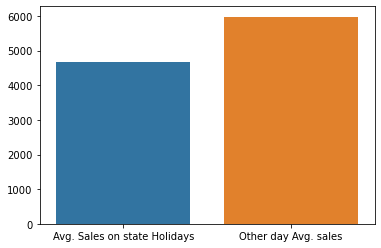

In [41]:
# Check Holodays date
y1, y2 = train_data[train_data['StateHoliday'] != '0'].Sales.mean(), train_data[train_data['StateHoliday'] == '0'].Sales.mean()
sns.barplot(y = [y1, y2], x = ['Avg. Sales on state Holidays', 'Other day Avg. sales'])
plt.title = "Promo Distribution on train dataset"
plt.show()

### The average Sales on State Holidays are less compared to other days (non-holidays)

## Effect of Seasonal (Christmas, Easter) on sales

### Extract and Adding Day, month and Year columns in the data from Date column

In [65]:
combined_train_store_data.Date = pd.to_datetime(combined_train_store_data.Date)
combined_train_store_data['day'] = combined_train_store_data.Date.dt.day
combined_train_store_data['month'] = combined_train_store_data.Date.dt.month
combined_train_store_data['year'] = combined_train_store_data.Date.dt.year
combined_train_store_data.head(4)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,day,month,year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,31,7,2015,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,31,7,2015,31,7,2015


### Sales variation per days, months and years

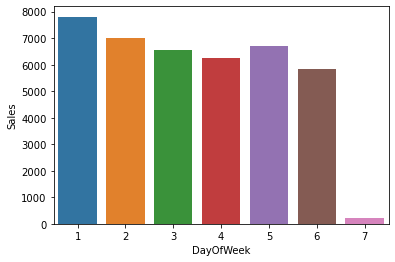

In [74]:

values = combined_train_store_data.groupby(combined_train_store_data.DayOfWeek).mean().Sales
sns.barplot(y = values, x = values.index)
plt.show()

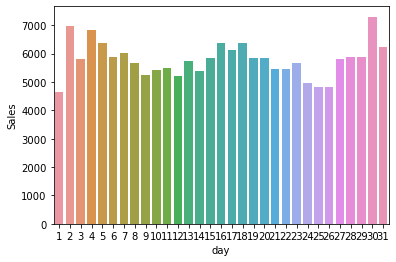

In [72]:
values = combined_train_store_data.groupby(combined_train_store_data.day).mean().Sales
sns.barplot(y = values, x = values.index)
plt.show()

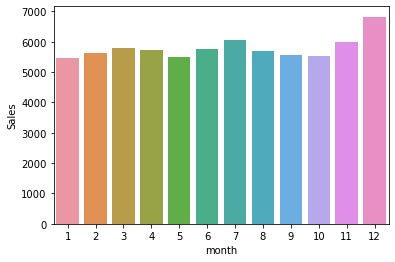

In [77]:
values = combined_train_store_data.groupby(combined_train_store_data.month).Sales.mean()
sns.barplot(y = values, x = values.index)
plt.show()

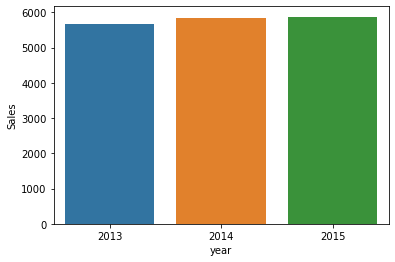

In [69]:
values = combined_train_store_data.groupby(combined_train_store_data.year).mean().Sales
sns.barplot(y = values, x = values.index)
plt.show()

### Results:
#### Sales vs Week days: On Monday the sales are highest followed by Tuesday, and then are lower on weekends, where on Sunday is lowest (Probably most of the stores are closed)
#### Sales Vs Month days: Most sales are done at the begining (2-6th days), middle (13-20th days) and at the end (27-30th days) of the month 
#### Sales Vs Months: Most sales are done at the beggining of the year (January to April, with March having most sales), middle of the year (June to August), and at the end of the year (November and December, with December having highest Sales of all the months)

#### Sales Vs Year: Sales increases as the year increases, from 2013 to 2015